# Get g distribution for a synthetic transit

Transit modeling with batman https://www.cfa.harvard.edu/~lkreidberg/batman/tutorial.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import photoeccentric as ph
from tqdm import tqdm
import batman
import pandas as pd
import scipy.constants as c

import astropy.units as u
from astropy.timeseries import BoxLeastSquares

from scipy.optimize import curve_fit

import emcee

import PyAstronomy.pyasl as pya

### Functions used in this notebook defined here

In [2]:
#Assuming a circular orbit --

def get_T14(p, rprs, a, i, ecc_prior=False, e=None, w=None):
    """
    Period: seconds
    rprs: rp in stellar radii
    a: semi-major axis in stellar radii (a/Rs)
    i: degrees
    
    returs T14: seconds
    """
    
    rs_a = 1./a #Rs/a - rstar in units of semimajor axis
    b = a*np.cos(i*(np.pi/180)) #convert i to radians
    
    T14 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1+rprs)**2)-b**2))/np.sin(i*(np.pi/180)))
    
    if ecc_prior==True:
        chidot = np.sqrt(1-e**2)/(1+e*np.sin(w*(np.pi/180.))) #Equation 16 in exoplanet textbook
        return T14*chidot
    
    return T14

In [3]:
#Assuming a circular orbit --

def get_T23(p, rprs, a, i, ecc_prior=False, e=None, w=None):
    """
    Period: seconds
    rprs: rp in stellar radii
    a: semi-major axis in stellar radii (a/Rs)
    i: degrees
    
    returs T23: seconds
    """
    
    rs_a = 1./a #Rs/a - rstar in units of semimajor axis
    b = a*np.cos(i*(np.pi/180)) #convert i to radians
    
    T23 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1-rprs)**2)-b**2))/np.sin(i*(np.pi/180)))
    
    if ecc_prior==True:
        chidot = np.sqrt(1-e**2)/(1+e*np.sin(w*(np.pi/180.))) #Equation 16 in exoplanet textbook
        return T23*chidot
    
    return T23

In [4]:
# #Assuming a circular orbit --

# def get_T23(p, rprs, T14, a, i):
#     """
#     Period: seconds
#     rprs: rp in stellar radii
#     T14: seconds
#     a: semi-major axis in stellar radii
#     i: degrees
    
#     returs T23: seconds
#     """
    
#     ing_eg = 2*pya.ingressDuration_Rs(a, rprs, i, p)
    
#     T23 = T14-ing_eg
    
#     print('Ingress and egress ', ing_eg)
#     #print('T23 ', T23)
    
#     return T23

In [5]:
def density(mass, radius):
    """Get density of sphere given mass and radius.

    Parameters
    ----------
    mass: float
        Mass of sphere (kg)
    radius: float
        Radius of sphere (m)
    norm: float, default None
        Value to normalize to (kg m^-3)
    """

    return mass/((4.0/3.0)*np.pi*radius**3)

In [6]:
def calc_a(period, smass, srad):
    """Calculates semi-major axis from planet period and stellar mass
    Kepler's 3rd law (newton)
    
    Parameters
    ----------
    period: float
        Planet period in DAYS
    smass: float
        Stellar mass in SOLAR MASS
    srad: float
        Stellar radius in SOLAR RADII

    Returns
    -------
    a: float
        Semi-major axis of planet's orbit (normalized to stellar radii)
    """
    
    p_yr = period/365.0

    
    a_cube = (p_yr**2)*smass
    a_au = np.cbrt(a_cube) #a in AU
    a_solr = a_au*215.032 #a in solar radii
    
    a = a_solr/srad #a in stellar radii
    
    return a

In [374]:
def find_density_dist_symmetric(ntargs, masses, masserr, radii, raderr):
    """Gets symmetric stellar density distribution for stars.
    Symmetric stellar density distribution = Gaussian with same sigma on each end.

    Parameters
    ----------
    ntargs: int
        Number of stars to get distribution for
    masses: np.ndarray
        Array of stellar masses (solar mass)
    masserr: np.ndarray
        Array of sigma_mass (solar mass)
    radii: np.ndarray
        Array of stellar radii (solar radii)
    raderr: np.ndarray
        Array of sigma_radius (solar radii)

    Returns
    -------
    rho_dist: np.ndarray
        Array of density distributions for each star in kg/m^3
        Each element length 1000
    mass_dist: np.ndarray
        Array of symmetric Gaussian mass distributions for each star in kg
        Each element length 1000
    rad_dist: np.ndarray
        Array of symmetric Gaussian radius distributions for each star in m
        Each element length 1000
    """

    rho_dist = np.zeros((ntargs, 1000))
    mass_dist = np.zeros((ntargs, 1000))
    rad_dist = np.zeros((ntargs, 1000))

    #star: indexing star
    #point: indexing PDF point for star
    for star in tqdm(range(ntargs)):

        rho_temp = np.zeros(1000)
        mass_temp = np.zeros(1000)
        rad_temp = np.zeros(1000)

        #####
        smass_kg = 1.9885e30 
        srad_m = 696.34e6
        
        mass_temp = np.random.normal(masses[star]*smass_kg, masserr[star]*smass_kg, 1000)
        rad_temp = np.random.normal(radii[star]*srad_m, raderr[star]*srad_m, 1000)
        #####

        #for j from 0 to 1200
        #for each point in individual star PDF
        #Adding each density point to rho_temp (specific to this star)
        for point in range(len(mass_temp)):
            #if mass_dist[point] >= 0. and rad_dist[point] >= 0:
            rho_temp[point] = density(mass_temp[point], rad_temp[point])

        #Now rho_temp is a n-long array with this star. We want it to be 1000-long exactly

        while len(rho_temp) > 1000:
            temp_ind = np.random.randint(0, len(rho_temp)-1)
            rho_temp = np.delete(rho_temp, temp_ind)
            mass_temp = np.delete(mass_temp, temp_ind)
            rad_temp = np.delete(rad_temp, temp_ind)
        else:
            rho_dist[star] = rho_temp
            mass_dist[star] = mass_temp
            rad_dist[star] = rad_temp

    return rho_dist, mass_dist, rad_dist

In [375]:
def get_rho_circ(rprs, T14, T23, p):
    """Returns stellar density, assuming a perfectly circular planetary orbit.

    Parameters
    ----------
    rprs: float
        Planet radius/stellar radii
    T14: float
        Total transit time - first to fourth contact (seconds)
    T23: float
        Full transit time - second to third contact (seconds)
    p: float
        Orbital period (seconds)

    Returns
    -------
    rho_circ: float
        Stellar density, assuming a circular orbit (kg/m^3)
    """

    delta = rprs**2
    
    rho_circ = (((2*(delta**(1/4)))/np.sqrt(T14**2-T23**2))**3)*((3*p)/(c.G*(c.pi**2)))

#     print(rprs, delta, T14, T23, p)
#     print(((3*p)/(c.G*(c.pi**2))))
#     print(((2*(delta**(1/4)))/np.sqrt(T14**2-T23**2))**3)
    
    return rho_circ

In [376]:
#def get_g_dist_synthetic(rhos, p, perr, rprs, rprserr, a, i, T14, T14err, n_rhos):
def get_g_dist_synthetic(rhos, p, perr, rprs, rprserr, a, i, T14, T14err, T23, T23err, n_rhos):
    """Gets g distribution for a KOI.
    
    Parameters
    ----------
    row: int
        Row in pandas.dataframe of info from Exoplanet Archive. (change this to take KIC/KOI)
    n_rhos: int
        Number of values in distribution
        
    Returns
    -------
    gs: np.array
        g distribution for star/planet.
    """

    gs = np.zeros((len(rhos)))

    rho_circ = np.zeros(len(rhos))
    rho_ratios = np.zeros(len(rhos))
    T23_dist = np.zeros((len(rhos)))

    per_dist = np.random.normal(p, perr, size=1000)
    rprs_dist = np.random.normal(rprs, rprserr, size=1000)

    T14_dist = np.random.normal(T14, T14err, size=1000)
    T23_dist = np.random.normal(T23, T23err, size=1000)

    #for j in tqdm(range(len(rhos))): #for element in histogram for star:
    #All times in seconds
    for j in tqdm(range(len(rhos))):

#         per_dist[j] = per_dist[j]*86400.
#         T14_dist[j] = T14_dist[j]*86400.
#         T23_dist[j] = T23_dist[j]*86400.
        
        rho_circ[j] = get_rho_circ(rprs_dist[j], T14_dist[j], T23_dist[j], per_dist[j])

        g = ph.get_g(rho_circ[j], rhos[j])
        gs[j] = g

        
        
    return gs, rho_circ, rhos, T14_dist, T23_dist

In [590]:
def stellar_params_from_archive(df, kep_name):
    """Get stellar parameters for the host of a KOI from exoplanet archive (downloaded data).
    
    Parameters
    ----------
    df: pandas.DataFrame
        dataframe of exop. archive downloaded data
    kep_name: str
        Kepler name of planet
    
    Returns
    -------
    smass: float
        Stellar mass (solar mass)
    srad: float
        Stellar radius (solar radius)
    limbdark_mod: str
        Limb darkening model
    ldm_c1: float
        Limb darkening coefficient 1
    ldm_c2: float
        Limb darkening coefficient 2
    
    """
    smass = float(df.loc[df['kepler_name'] == kep_name].koi_smass) #solar mass
    srad = float(df.loc[df['kepler_name'] == kep_name].koi_srad) #solar radius

    limbdark_mod = str(df.loc[df['kepler_name'] == kep_name].koi_limbdark_mod) #LDM Model
    ldm_c2 = float(df.loc[df['kepler_name'] == kep_name].koi_ldm_coeff2) #LDM coef 2
    ldm_c1 = float(df.loc[df['kepler_name'] == kep_name].koi_ldm_coeff1) #LDM coef 1

    return smass, srad, limbdark_mod, ldm_c1, ldm_c2

In [703]:
def planet_params_from_archive(df, kep_name):
    """Get stellar parameters for the host of a KOI from exoplanet archive (downloaded data).
    
    Parameters
    ----------
    df: pandas.DataFrame
        dataframe of exop. archive downloaded data
    kep_name: str
        Kepler name of planet
    
    Returns
    -------
    period: float
        Orbital period (days)
    rprs: float
        Planet radius (stellar radii)
    a: float
        Semi-major axis (stellar radii)
    e: float
        Eccentricity
    w: float
        Longitude of periastron (degrees)
    i: float
        Inclination (degrees)
    
    """

    period = float(df.loc[df['kepler_name'] == kep_name].koi_period) #solar mass
    rprs = float(df.loc[df['kepler_name'] == kep_name].koi_ror) #solar radius
    
    
    srad = float(df.loc[df['kepler_name'] == kep_name].koi_srad) #stellar radius (Sol. rad)
    a_au = float(df.loc[df['kepler_name'] == kep_name].koi_sma) #semi-major axis (AU)
    a_solrad = a_au*215.032 #semi-major axis (Sol. rad)
    
    a = a_solrad/srad

    e = float(df.loc[df['kepler_name'] == kep_name].koi_eccen) #LDM Model
    w = float(df.loc[df['kepler_name'] == kep_name].koi_longp) #LDM coef 2
    i = float(df.loc[df['kepler_name'] == kep_name].koi_incl) #LDM coef 1

    return period, rprs, a, e, w, i

Take stellar parameters from a real star in the sample and put a planet around it.

In [704]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

In [705]:
kepname = "Kepler-446 b"

smass, srad, _, ldm_c1, ldm_c2 = stellar_params_from_archive(spectplanets, kepname)
period, rprs, a, _, _, i = planet_params_from_archive(spectplanets, kepname)

#a = calc_a(period, smass, srad)

rstar_a = 1/a

print('Stellar mass: ', smass, 'Stellar radius: ', srad)
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a: ', a)
print('Rs/a: ', rstar_a)
print('i: ', i)

Stellar mass:  0.32799999999999996 Stellar radius:  0.32799999999999996
Period:  1.5654126130000001 Rp/Rs:  0.048437
a:  11.931653658536588
Rs/a:  0.0838106794429574
i:  89.99


In [706]:
""" Creating mass, masserr, radius, and raderr arrays """

masses = [np.random.normal(smass, 0.05, size=100)]
radii = [np.random.normal(srad, 0.1, size=100)]

###### Find the density of this "star" based on available information (mass and radius)

In [707]:
rho, ms, rs = find_density_dist_symmetric(1, [smass], [0.05], [srad], [0.05])
rho[0].flatten();
#rhos = rho[0][0]
rhos = rho[0]
rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

100%|██████████| 1/1 [00:00<00:00, 367.92it/s]


##### Create a transit model with planet params above.

In [708]:
time = np.linspace(-24, 24, 5000)

In [709]:
def planetlc(time, per, rp, a, inc):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = a                        #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.8                       #eccentricity
    params.w = 90.0                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [710]:

flux = planetlc(time, period, rprs, a, i)

# Adding gaussian noise
noise = np.random.normal(0,0.0001,len(time))
nflux = flux+noise

In [711]:
#plt.plot(time, nflux)

In [712]:
def planetlc_fitter(time, per, rp, a, inc):
    """Always assumes e=0.
    w is a free parameter."""
    
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = a                        #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0                       #eccentricity
    params.w = 0.0                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

## Fit transit

#### Astropy BLS

In [713]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

In [714]:
# plt.plot(periodogram.period, periodogram.power)
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]
# plt.xlabel('Period (days)')
# plt.ylabel('Power')
# plt.vlines(per_guess, 0, 3, color='r')

#### Least-squares using BLS period guess

In [715]:
# Normally I would use the BLS depth, ingress+egress, etc. to guess the other planet params 
# but I'm not going to do that right now because I'm just testing my get_g function

p0 = [per_guess, 0.05, 12, 86.4]
popt, pcov = curve_fit(planetlc_fitter, xdata=time, ydata=nflux, p0=p0)
fit = planetlc(time, *popt)

In [716]:
# plt.scatter(time, nflux, label='Light curve', s=5)
# plt.plot(time, fit, label='Fit', c='orange')
# plt.legend()

In [717]:
# need to measure T14 and T23 photometrically (from the model), instead of calculating it based on planet params.
# that won't work because it always assumes/produces a circular orbit

In [718]:
ttime = time[2470:2530]
tfit = fit[2470:2530]

In [719]:
diffs = np.append(np.diff(tfit)/np.diff(ttime), 0)

In [720]:
# plt.plot(ttime, diffs)
# plt.axvline(ttime[np.argmin(diffs)])
# plt.axvline(ttime[np.argmax(diffs)])

In [721]:
notzeros = [i for i, e in enumerate(tfit) if e != 1.0]

In [722]:
# plt.plot(time, nflux, alpha=0.6)
# plt.plot(ttime, tfit, c='orange')
# plt.xlim(-0.1, 0.1)

# plt.axvline(ttime[np.argmin(diffs)+1], color='r')
# plt.axvline(ttime[np.argmax(diffs)], color='r')

# plt.axvline(ttime[notzeros[0]-1], color='b')
# plt.axvline(ttime[notzeros[-1]+1], color='b')


In [723]:
# T14 = ttime[notzeros[-1]+1]-ttime[notzeros[0]-1]
# T23 = ttime[np.argmax(diffs)]-ttime[np.argmin(diffs)+1]

In [724]:
p = popt[0]*86400 #4.99 days
perr = 0.001*86400

rprs = popt[1] #0.0704 stellar radii
rprserr = 0.001

a = popt[2] #stellar radii

i = popt[3] #degrees 


#T14n = T14*86400
T14n = get_T14(p, rprs, a, i)
#T14n = get_T14(p, rprs, a, i, e, w)
#T14n = get_T14(p, rprs, a, i, 0.2, 0.0)
T14err = 0.0001*86400

#T23n = T23*86400
T23n = get_T23(p, rprs, a, i)
#T23n = get_T23(p, rprs, a, i, e, w)
#T23n = get_T23(p, rprs, a, i, 0.2, 0.0)
T23err = 0.0001*86400

In [725]:
w

0.0

In [726]:
p

135260.38376183738

In [727]:
rprs

0.04877247890174689

In [728]:
i

88.99478875362614

In [729]:
a

27.77827753759896

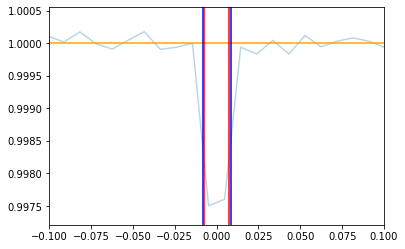

In [730]:
plt.plot(time, nflux, alpha=0.3)
plt.plot(ttime, tfit, c='orange')
plt.xlim(-0.1, 0.1)

plt.axvline(0-(T14n/86400)/2., color='b')
plt.axvline(0+(T14n/86400)/2., color='b')

plt.axvline(0-(T23n/86400)/2., color='r')
plt.axvline(0+(T23n/86400)/2., color='r')


In [731]:
gs_t, rhoc, rhoe, T14s, T23s = get_g_dist_synthetic(rhos, p, perr, rprs, rprserr, a, i, T14n, T14err, T23n, T23err, 100)
gs = gs_t

100%|██████████| 1000/1000 [00:00<00:00, 88732.66it/s]


In [732]:
np.mean(gs)

2.3598363117523005

In [733]:
np.mean(rhoc)

167435.91191122477

In [734]:
np.mean(rhoe)

15012.728389109312

In [735]:
gs_sigmaminus, gs_sigmaplus = ph.get_sigmas(gs)

In [736]:
def log_likelihood(theta, g, gerr):
    """Log of likelihood
    model = g(e,w)
    gerr = sigma of g distribution
    """
    w, e = theta
    model = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    """Log of prior
    e between 0 and 1
    w between -90 and 300
    """
    w, e = theta
    if 0.0 < e < 1.0 and -90.0 < w < 300.0:
        return 0.0
    return -np.inf

def log_probability(theta, g, gerr):
    """Log of probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, g, gerr)

In [737]:
#Guesses
w_guess = 80.0
e_guess = 0.35

In [738]:
solnx = (w_guess, e_guess)

In [739]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [740]:
g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

In [741]:
g_mean

2.3598363117523005

In [742]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:07<00:00, 704.38it/s]


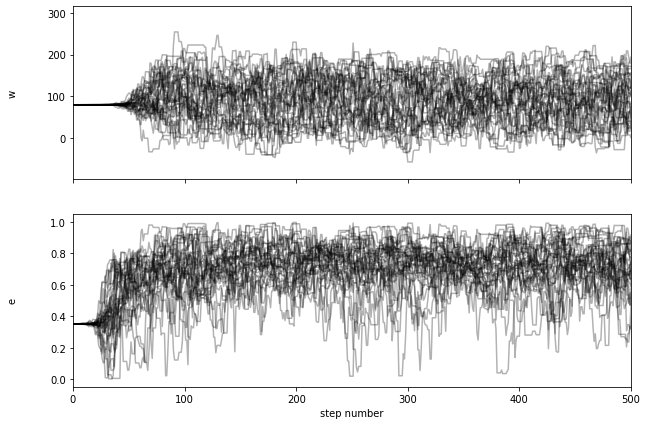

In [743]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

In [744]:
import corner

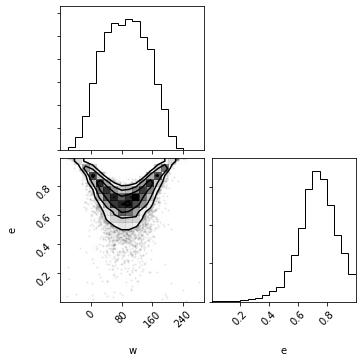

In [745]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)